<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/seq2seq_Part_E_Encoder_Decoder_for_variable_Input_Output_size_with_Teacher_Forcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART E: Encoder-Decoder for Variable Input And Output Sizes: Padding & Masking
Welcome to  **Part E** of the Seq2Seq Learning Tutorial Series.
In this tutorial, we will design an Encoder-Decoder model to handle **variable-size** input and output sequences by using three methods. First, we  will apply **Padding** to the input and output datasets. Then, we will append the **Masking** layer to the Encoder-Decoder model to efficiently process the padded data. Lastly, we design the model such that decoder will stop whenever it generates a special **STOP** symbol. To improve the training process, we will implement the **Teacher Forcing** technique which we had covered in **Part D**. 


If you would like to follow up on all Seq2Seq tutorials, please **subscribe** to [my YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists) or **follow** [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **Notifications** so that you will be notified when ***new parts are uploaded***.

You can access this **Colab Notebook** using [the link](https://colab.research.google.com/drive/1cxDOWY7PQSx-tRy8inE2IG7-xGpVJWNP?usp=sharing) given in the video description below.

If you are ready, let's get started!


---
# References:



**Blogs**:

* [Tensorflow/Keras Masking Padding official website](https://www.tensorflow.org/guide/keras/masking_and_padding)

* [Tensorflow/Keras LSTM official website](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

* [A ten-minute introduction to sequence-to-sequence learning in Keras by Francois Chollet](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

* [How to Develop an Encoder-Decoder Model with Attention in Keras by Jason Brownlee](https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/)

**Presentations:**

* [LSTM from a programmer's perspective by Murat Karakaya Akademi](https://github.com/kmkarakaya/ML_tutorials/raw/bf15d1d5aebd23e05420c12f3c954abea9204b1f/ppt/HOW%20KERAS%20LSTM%20WORKS.pptx)

**Videos:**
* [LSTM from scratch by Murat Karakaya Akademi](https://youtu.be/7nnSjZBJVDs)

**Notebooks**:
* [LSTM intro by Murat Karakaya Akademi](https://colab.research.google.com/drive/1kG5pUczEtqdDtMHiNL-mvgTi-5-Y058t?usp=sharing)
* [Recap LSTM outputs by Murat Karakaya Akademi](https://colab.research.google.com/drive/1nUazJkXcRZi-XiXCr6sEgCy2Z5Mhze1n?usp=sharing)



---
# Import Dependencies & Auxiliary Functions

In [ ]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found
time: 3.3 ms


In [ ]:
#@title Version Info
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)


tf version:  2.3.0
tf.keras version: 2.4.0
time: 4.04 ms


In [ ]:
#@title Time
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.74 s


In [ ]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

from scipy.ndimage.interpolation import shift

time: 7.88 ms


In [ ]:
#@title Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences


# generate a sequence of random integers
def generate_sequence(min_timesteps_in, max_timesteps_in, n_unique):
	return [randint(1, n_unique-1) for _ in 
	        range( randint(min_timesteps_in, max_timesteps_in))]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(min_timesteps_in, max_timesteps_in, vocabulary_size)
	sequence_out = sequence_in[::-1]
	sequence_out =[i for i in sequence_out if i%2 ==0 and i != 0]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)

	return X,y


def create_dataset(train_size, test_size, 
                   min_timesteps_in, max_timesteps_in, vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size) for _ in range(train_size)]
	
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nSample X and y sequences (in Raw Format)')
		for i in range(5):
			print('X[',i,']=%s' % (one_hot_decode(X_train[i])), '........ y[',i,']=%s' % (one_hot_decode(y_train[i])))

		print('\nEach input and output sequences are converted one_hot_encoded format with input_dimension = ',
		      vocabulary_size)
		print('X[0]=\n%s' % (X_train[0]))
		print('y[0]=\n%s' % (y_train[0]))
	
		print('\nGenerated sequence datasets as follows [sample_size,time_steps, input_dimension]')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

time: 51.5 ms


In [ ]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[0][sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)
	


time: 40.4 ms


---
# SEQ2SEQ LEARNING SERIES:
* This is the **Part E** of the Seq2Seq Learning series.

* **Please check out the previous parts** to ***refresh*** the necessary background knowledge in order to follow this part with ease.

You can access all my **SEQ2SEQ Learning** videos on **[Murat Karakaya Akademi Youtube channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists?view=1&flow=grid)** in [ENGLISH](https://www.youtube.com/playlist?list=PLQflnv_s49v-4aH-xFcTykTpcyWSY4Tww) or in [TURKISH](https://www.youtube.com/playlist?list=PLQflnv_s49v97hDXtCo4mgje_SEiJ0_hH)

You can access  [my blog on Medium](https://medium.com/@kmkarakaya)

**Part A: AN INTRODUCTION TO SEQ2SEQ LEARNING AND A SAMPLE SOLUTION WITH MLP NETWORK** 
 
   * YouTube Videos in [ENGLISH](https://youtu.be/9TEPkRLhgSc) or [TURKISH](https://youtu.be/p2QlkuV4ito) / [Medium Post](https://medium.com/@kmkarakaya/part-a-introduction-to-seq2seq-learning-a-sample-solution-with-mlp-network-95dc0bcb9c83?sk=2063e3c62b1989efedf6625ac626c2ee) / [Colab Notebook](https://colab.research.google.com/drive/1fffqeeJsY89LuxsEl_7Re33nCWGusjCj?usp=sharing)

**Part B: SEQ2SEQ LEARNING WITH RECURRENT NEURAL NETWORKS (LSTM)** 

   * YouTube Video in [ENGLISH](https://youtu.be/7L5bkMu0Pgg) or [TURKISH](https://youtu.be/UA4rDcq5Cuo) / [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-b-using-lstm-layer-in-a-recurrent-neural-network-9be629bb71e2?source=friends_link&sk=0b6e0f34592100b991664c55061ca394) / [Colab Notebook](https://colab.research.google.com/drive/1DBaHgsoPJCoj8SXAqNqQtKqAtwrUc4qS?usp=sharing)


**Part C: SEQ2SEQ LEARNING WITH A BASIC ENCODER DECODER MODEL** 

   * YouTube Video in [ENGLISH](https://youtu.be/iHJkfsV9cqY) or [TURKISH](https://youtu.be/SZNqENbc9f4)/ [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-c-basic-encoder-decoder-a7f536f5f510) / [Colab Notebook](https://colab.research.google.com/drive/1ErnVEZOmlu_nInxaoLStW0BHzgT4meVj?usp=sharing)

**Part D: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL WITH TEACHER FORCING** 

   * YouTube Video in [ENGLISH](https://youtu.be/RRP0czWtOeM) or [TURKISH](https://youtu.be/JVIiPaCFB78) / [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-d-encoder-decoder-with-teacher-forcing-18a3a09a096) / [Colab Notebook](https://colab.research.google.com/drive/1TNUB8vsZimVZl_wktWS1ac4wyw8kaNLW?usp=sharing)



**Part E: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL WITH TEACHER FORCING FOR VARIABLE INPUT AND OUTPUT SIZE: MASKING & PADDING** 

   * YouTube Video in [ENGLISH]() or [TURKISH]() / [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-e-encoder-decoder-for-variable-input-output-size-with-teacher-forcing-92c476dd9b0) / [Colab Notebook](https://colab.research.google.com/drive/1C1m-uNsWqhFOS2naFXNuxh851YkixYeZ?usp=sharing)

**Part F: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + BAHDANAU ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1VFfeP3eiauYCRvW8vMvL0NRKaOtcGz3J?usp=sharing)


**Part G: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + LUONG ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1N0ycXm7Lq3jWzbJERRy6rwL1Ux4hmlWM?usp=sharing)


---
# WHY WE HAVE SO MANY PARTS?
* Our aim is to code an Encoder Decoder Model with Attention. 
* However, I would like to develop the solution by showing the shortcomings of other possible approaches.
* Therefore, in the first 2 parts, we will observe that initial models have their own weaknesses.
* We also understand why Encoder Decoder paradigm is so successful.

**So, please patiently follow the parts as we develop a better solution :)**

---
# A Simple Seq2Seq Problem: The reversed sequence problem
Assume that:
* We are given a **parallel data set** including X (input) and y (output) such that X[i] and y[i] have ***some*** relationship.

* We use the **parallel data sets** to train a **seq2seq** model which would learn 

  * how to **convert/transform an input sequence from X 
to an output sequence in y**

* For instance: we are given the **same book's text** in English (X) and in Turkish (y). Thus the **statement X[i]** in English is translated into Turkish as **y[i] statement**. We use these parallel date sets to train a **seq2seq** model which would learn how to **translate from English to Turkish**


However, to set up an ***easily traceable*** example, I opt out to prepare a rather simple sequence learning problem. 

* Consider two parallel sequence datasets **X** and **y** as below:

 X[0]=[3, 2, 9, 4]..................................y[0]=[4, 2]

 X[1]=[7, 6, 5, 2, 5, 2].......................... y[1]=[2, 2, 6]

 X[2]=[1, 7, 5, 1, 3]...............................y[2]=[]

 **NOTICE THAT** input (X) and output (y) sequences have **variable lengths** 

* Actually, for this simple Seq2Seq Learning problem,  I formulated the **y** sequence to be **the even numbers  of the given sequence (X) in reverse order**. 
* **Assume** that you do not know that relation: You only have 2 parallel datasets X and y

In this part, we will develop an encoder-decoder model for the above **variable-size** input and output sequences

* To create parallel datasets X and y, I already prepare a function and an interface to configure it as below









In [ ]:
#@title Configure problem

min_timesteps_in =   4#@param {type:"integer"}
max_timesteps_in =   8#@param {type:"integer"}

input_dimension = 10   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1



# generate datasets
train_size= 4000 #@param {type:"integer"}
test_size = 200  #@param {type:"integer"}

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, min_timesteps_in, max_timesteps_in, input_dimension , verbose=True)




Sample X and y sequences (in Raw Format)
X[ 0 ]=[3, 5, 9, 7, 7, 6, 5, 2] ........ y[ 0 ]=[2, 6]
X[ 1 ]=[2, 8, 9, 4, 6, 7, 7] ........ y[ 1 ]=[6, 4, 8, 2]
X[ 2 ]=[1, 2, 9, 6, 7, 9, 7, 9] ........ y[ 2 ]=[6, 2]
X[ 3 ]=[6, 6, 8, 3, 8, 4] ........ y[ 3 ]=[4, 8, 8, 6, 6]
X[ 4 ]=[5, 1, 2, 2] ........ y[ 4 ]=[2, 2]

Each input and output sequences are converted one_hot_encoded format with input_dimension =  10
X[0]=
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
y[0]=
[[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]

Generated sequence datasets as follows [sample_size,time_steps, input_dimension]
X_train.shape:  (4000,) y_train.shape:  (4000,)
X_test.shape:  (200,) y_test.shape:  (200,)
time: 176 ms


**IMPORTANT**: 
1. Pay attention to **shapes** of X and y  data sets. Even though we created 3D arrays [***sample_size, time_steps, input_dimension***], above we observed  that Python reports their corresponding shapes as (**4000,**) or (**200,**). Why? Because, the **time_steps** dimension does **NOT** have a **fixed** size! *time_steps* has **variable** sizes! Therefore, Python can NOT print **the complete shape of the dataset**.

2. I **reserve 0 (zero)** as a **special symbol** and therefore I do **NOT use** it in sequences as a number!

---
# How to handle variable Input and Output sequence size
* In our previous parts, we  **assumed** that input and output sequence sizes of all samples are **fixed and known in advance**
* Now, we relax this requirement by assuming **input & output sequence sizes may vary** from sample to sample
* However, in Artificial Neural Network models (including encoder decoder models), the first and last layers have a **fixed number of neurons** and ***during training***, we need to provide **fixed-size samples** in the input (X) and output (y) data sets.  
* Therefore, ANN models should be trained with samples structured in a fixed-size shape.
* However, since we have variable-size input/output samples, we need to convert them into a fixed-size shape.
* The popular solution has two parts:
  * **During training**: we will use **padding** and **masking** to make **all sample sequence sizes equal**.
  * **During inference**: For variable output sequence size, we will modify the decoder such that it will work in a loop and stop generating output when a **condition is met**. This condition can be in satisfied in two ways:
    * If the decoder generated the **maximum number** of outputs defined by the user, ***or***
    * If the decoder generated a special "**STOP**" symbol

Don't worry, we will implement the above solution step by step. 

So let's get started!



---
#Padding
* **Padding** means **appending a special symbol** to the *beginning* or *end* of a sequence
* The special symbol is mostly **0 (zero)**  but ***can be any symbol which is not used as a value in the sequences***
* We will use padding to **extend** the given sequence to a specific size
* Assume we are given the sequence [4, 6, 8], we can pad ***two*** 0 (zeros) in two different ways:
  * **post-padding:** We append the padding **at the end of** the sequence such that the resulting sequence becomes [4, 6, 8, 0, 0] 
  * **pre-padding:** We can also append the padding **to the beginning of** the sequence: [0, 0, 4, 6, 8]

* **Notice that:** Even the original information ([4, 6, 8]) is reserved, the **size of the padded sequence** ([4, 6, 8, 0, 0] or [0, 0, 4, 6, 8] ) is **changed/incremented** to **5 instead of 3**!

* **Important:** Tensorflow/Keras **recommends** using "**post**" padding when working with RNN layers in order to be able to use the ***CuDNN*** implementation of the layers. Thus, we will use post-padding in this tutorial.

---
## How to use padding in variable-size input/output sequences?

* First, we will find out the **maximum number of time steps** in input/output data sets
* Then, we will append the **necessary number** of paddings to the end of each sequence such that their number of time steps will be equal to the maximum number of time steps in the data set. 
* In the end, all the input/output sequences will have the **same** number of time steps

# What would be the effect of padding in training & testing
* Remember that we had **reserved 0 (zero)** when we created the X and y datasets
* We reserved 0 (zero) for padding
* **In training** 
  * encoder will consume all the sequence and the paddings 
  * decoder will learn to produce 0 (zero) when the output sequence finishes 
* **In testing**
  * encoder will consume all the sequence and the paddings
  * decoder will stop predicting 
    * when it generates "**STOP**" symbol (0 zero) as output, or
    * when it exceeds the **number of maximum outputs** defined by the user 

---
## Let's apply paddings to input/output datasets



First we will find out the **maximum** sequence size for input/output sequences in the **train** data set:


In [ ]:
max_input_sequence= max(len(seq) for seq in X_train)
max_output_sequence= max(len(seq) for seq in y_train)

print('max_input_sequence: ', max_input_sequence)
print('max_output_sequence: ', max_output_sequence)

max_input_sequence:  8
max_output_sequence:  8
time: 4.5 ms


In this example, `max_input_sequence` and `max_ouput_sequence` are **equal** but they could be different for your datasets. The point is you need to handle input and output sequences **separately**!

Then, we will append **necessary number** of paddings to the end of each input sequence such that their number of time steps will be equal to the maximum number of time steps in the data set.

We can use `pad_sequences()` function from Keras preprocessing library as below.

  `pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)`

**Note that**: 
1. If the `maxlen` argument is NOT provided, the function automatically sets `maxlen` to the maximum sequence size in the samples. However, for the sake of clarity, I will provide `max_input_sequence` and `max_ouput_sequence` to the `pad_sequences()` function. 

2. I will provide the padding  `value` as `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]` which is the **one-hot-encoded representation** of ***0 (zero) padding***!

In [ ]:
from keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(X_train, maxlen= max_input_sequence, padding='post', value=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("X_train shape: ",X_train.shape)
print("X_train_padded shape: ",X_train_padded.shape)

y_train_padded = pad_sequences(y_train, maxlen= max_output_sequence, padding='post', value=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("y_train shape: ",y_train.shape)
print("y_train_padded shape: ",y_train_padded.shape)

X_train shape:  (4000,)
X_train_padded shape:  (4000, 8, 10)
y_train shape:  (4000,)
y_train_padded shape:  (4000, 8, 10)
time: 47.5 ms


**Important:** After padding, each sequence in X_train_padded has the same shape: (4000, **8, 10**): 8 time steps with a 10-dimension representation! That is, we have **fixed-size** input data set!

Let's see an example input before  and after padding:

In [ ]:
i=0
print("____Sample Input (Raw Format)____")
print("Original:\n", one_hot_decode(X_train[i]))
print("Padded:\n",one_hot_decode(X_train_padded[i]))
print("____Corresponding Output (Raw Format)____")
print("Original:\n", one_hot_decode(y_train[i]))
print("Padded:\n",one_hot_decode(y_train_padded[i]))

____Sample Input (Raw Format)____
Original:
 [3, 5, 9, 7, 7, 6, 5, 2]
Padded:
 [3, 5, 9, 7, 7, 6, 5, 2]
____Corresponding Output (Raw Format)____
Original:
 [2, 6]
Padded:
 [2, 6, 0, 0, 0, 0, 0, 0]
time: 7.21 ms


Let's apply padding to the **test** data set as well

In [ ]:
X_test_padded = pad_sequences(X_test, maxlen= max_input_sequence, padding='post', 
                              value=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("X_test shape: ",X_test.shape)
print("X_test_padded shape: ",X_test_padded.shape)

y_test_padded = pad_sequences(y_test, maxlen= max_output_sequence, padding='post', 
                              value=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("y_test shape: ",y_test.shape)
print("y_test_padded shape: ",y_test_padded.shape)

X_test shape:  (200,)
X_test_padded shape:  (200, 8, 10)
y_test shape:  (200,)
y_test_padded shape:  (200, 8, 10)
time: 11 ms


---
# Masking

* **Masking** is a way to tell ***sequence-processing layers*** that certain timesteps in an input are **missing**, and thus should be **skipped** when processing the data.
* Above we applied padding and all samples have a uniform sequence length. 
* Now, we need to inform the model that **some part of the data** is actually ***padding*** and should be **ignored** during processing. 
* That mechanism is called "**masking**".
* There are three ways to introduce input masks in Keras models:

  1. Add a  `keras.layers.Masking` layer.
  2. Configure a  `keras.layers.Embedding` layer with mask_zero=True.
  3. Pass a mask argument manually when calling layers that support this argument (e.g. RNN layers).

* In this tutorial, I will use **Masking layer**. As you remember, we **padded** the sequences with **0 (zero)** value. However, 0 value is converted ***one-hot encoding***. Thus, the mask value is the one-hot-encoded representation of `0` (zero) which is  `[1 0 0 0 0 0 0 0 0 0]` 

Therefore, we will create a **Masking layer** as below: 

`masking = tf.keras.layers.Masking(mask_value= [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])` 

#Encoder-Decoder model with Teacher Forcing

I **assume** that you have already studied previous parts and you have got familiar with **Encoder-Decoder model with Teacher Forcing**. 

If you have not, **please review at least Part D before continue**.





### A QUICK REMINDER: HOW TO TRAIN AN ENCODER - DECODER  WITH TEACHER FORCING  
The generic steps are as follows:
* Decoder produces the output sequence one by one 
* For each output, the decoder consumes a context vector and an input
* The **initial** **context** vector is created by the encoder
* The **initial input** is a special symbol for decoder to make it start, e.g. '***start***'
* Using initial context and initial input, decoder will generate the **first output**

However, the input to the decoder during the loop is different
* For the next output, 
  * decoder will use its **current state** ***as the context vector*** 
  * we (*the teacher!*) provide **the correct output** to the decoder  as ***input***
* Decoder will work in such a **loop** using its state and the **provided correct output** as the next step context vector and input **until** the generated output is a special symbol '***stop***' or the ***pre-defined maximum steps*** (length of output) is reached.


Therefore, we need to provide 2 input sequence TRAIN AN ENCODER - DECODER  WITH TEACHER FORCING such that
1. input to encoder: [4 7 2 0 0 0 0 0]
2. input to decoder: [0 2 4 0 0 0 0 0]

**Note that**: 
* Expected output is [2 4 0 0 0 0 0 0] ----even numbers in reverse order of input to encoder
* 0 (zero) is selected as special symbol for '**start**' and '**padding**'
* **input to decoder** is created by **shifting** the expected output by one time steps and  **adding** '*start*' token as the first token: [2 4 0 0 0 0 0 0] ------> [0 2 4 0 0 0 0 0]
* At the **first** cycle, decoder will use encoder's state and its first input which is 0 ([1 0 0 0 0 0 0 0] ) from [**0** 2 4 0 0 0 0 0] to generate the first expected output which is 2 from [2 4 0 0 0 0 0 0]
* Assume that decoder predicts 5 
  * in **generic** Encoder-Decoder model decoder will use 5 to generate/predict next token 
  * in **teacher forcing**, we (the teacher!) provide the second input from [0 **2** 4 0 0 0 0 0] which is **2** to the decoder to generate/predict next token 

Thus,  **during training**,  ***teacher*** enforces the decoder to condition itself to generate/predict next token according to the given correct input!
 


### HOW TO USE AN ENCODER - DECODER MODEL TRAINED WITH TEACHER FORCING FOR INFERENCE (PREDICTION)

* We need 2 input sequences:
1. Input for encoder: ***encoder_inputs***
2. Input for decoder: ***decoder_inputs***

* The ***encoder_inputs*** is given 
* However, this time we do not have correct outputs
* Therefore,  we will provide the **predicted output** as the input. 
* The first input is '*start*' and the other inputs will be the outputs from previous cycle

## PREPARE TRAINING DATA SETS
* To train the Encoder Decoder model we need to work on train data set such that we will prepare 3 data sets:

1. Input for encoder (***encoder_inputs***): training input data (X)
2. Input for decoder (***decoder_inputs***): shifted and appended START output data (y)
3. Target for decoder (***decoder_target_data***): output data (y)


In [ ]:
#Prepare TRAIN data set
encoder_input_data = X_train_padded.copy()
decoder_target_data = y_train_padded.copy()
decoder_input_data = decoder_target_data.copy()
for i, samples in enumerate(decoder_target_data):
  seq = one_hot_decode(samples)
  shifted= shift(seq, 1, cval=0)
  decoder_input_data[i]=one_hot_encode(shifted,input_dimension)
print("Data for Train")
print('encoder_input_data (X): ', one_hot_decode(encoder_input_data[1]))
print('decoder_input_data (teacher forcing): ',one_hot_decode(decoder_input_data[1]))
print('decoder_target_data (y):',one_hot_decode(decoder_target_data[1]))
print(encoder_input_data.shape)

#Prepare TEST data set
encoder_input_test = X_test_padded.copy()
decoder_target_test = y_test_padded.copy()
decoder_input_test= decoder_target_test.copy()
for i, samples in enumerate(decoder_target_test):
  seq = one_hot_decode(samples)
  shifted= shift(seq, 1, cval=0)
  decoder_input_test[i]=one_hot_encode(shifted,input_dimension)

Data for Train
encoder_input_data (X):  [2, 8, 9, 4, 6, 7, 7, 0]
decoder_input_data (teacher forcing):  [0, 6, 4, 8, 2, 0, 0, 0]
decoder_target_data (y): [6, 4, 8, 2, 0, 0, 0, 0]
(4000, 8, 10)
time: 379 ms


#### CREATE AN ENCODER - DECODER MODEL WITH TEACHER FORCING TO TRAIN
* Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

* complete the decoder model by adding a **Dense** layer with **Softmax** activation function for prediction of the next output
* Dense layer will output **one-hot encoded representation** as we did for input
* Therefore, we will use **input_dimension** number of neurons


In [ ]:
#@title LSTMoutputDimension
LSTMoutputDimension = 32 #@param {type:"integer"}


time: 3.39 ms


In [ ]:
# Define an input sequence and process it.
encoder_inputs= Input(shape=(max_input_sequence, input_dimension), name='encoder_inputs')

masking = tf.keras.layers.Masking(mask_value= [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
encoder_inputs_masked = masking(encoder_inputs)


encoder_lstm=LSTM(LSTMoutputDimension, return_state=True, name='encoder_lstm')
LSTM_outputs, state_h, state_c = encoder_lstm(encoder_inputs_masked)


# We discard `LSTM_outputs` and only keep the other states.
encoder_states = [state_h, state_c]



decoder_inputs = Input(shape=(None, input_dimension), name='decoder_inputs')
decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm')

# Set up the decoder, using `context vector` as initial state.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

#complete the decoder model by adding a Dense layer with Softmax activation function 
#for prediction of the next output
#Dense layer will output one-hot encoded representation as we did for input
#Therefore, we will use input_dimension number of neurons
decoder_dense = Dense(input_dimension, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# put together
model_encoder_training = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='model_encoder_training')

time: 542 ms


* compile the model

Model: "model_encoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 8, 10)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 32), (None,  5504        encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 32), ( 5504        decoder_inputs[0][0]             
                                                                 encoder_lstm

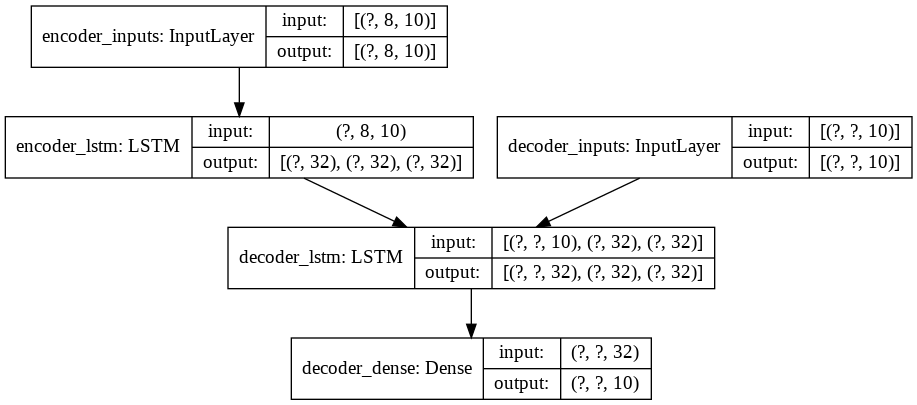

time: 96.3 ms


In [ ]:
model_encoder_training.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)

* We train the model while monitoring the loss on a held-out set of 20% of the samples as below.

* However, I prepared a custom `train_test` function for getting a detail report of training and testing.

``` python
# Run training
model_encoder_training.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=50,
          validation_split=0.2)
```



training for  50  epochs begins with EarlyStopping(monitor= val_loss, patience= 3 )....
Epoch 1/50
57/57 - 1s - loss: 1.6547 - accuracy: 0.5807 - val_loss: 0.9844 - val_accuracy: 0.6538
Epoch 2/50
57/57 - 0s - loss: 0.7958 - accuracy: 0.6839 - val_loss: 0.6615 - val_accuracy: 0.7113
Epoch 3/50
57/57 - 0s - loss: 0.5580 - accuracy: 0.7606 - val_loss: 0.5019 - val_accuracy: 0.7816
Epoch 4/50
57/57 - 0s - loss: 0.4580 - accuracy: 0.8041 - val_loss: 0.4504 - val_accuracy: 0.8066
Epoch 5/50
57/57 - 0s - loss: 0.4165 - accuracy: 0.8277 - val_loss: 0.4173 - val_accuracy: 0.8338
Epoch 6/50
57/57 - 0s - loss: 0.3771 - accuracy: 0.8532 - val_loss: 0.3737 - val_accuracy: 0.8512
Epoch 7/50
57/57 - 0s - loss: 0.3354 - accuracy: 0.8680 - val_loss: 0.3345 - val_accuracy: 0.8763
Epoch 8/50
57/57 - 0s - loss: 0.2965 - accuracy: 0.8816 - val_loss: 0.2963 - val_accuracy: 0.8766
Epoch 9/50
57/57 - 0s - loss: 0.2640 - accuracy: 0.8920 - val_loss: 0.2730 - val_accuracy: 0.8872
Epoch 10/50
57/57 - 0s - loss:

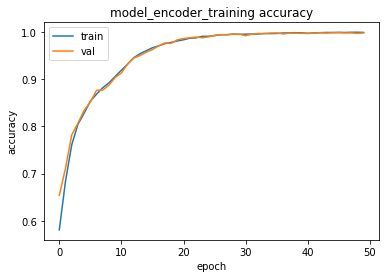

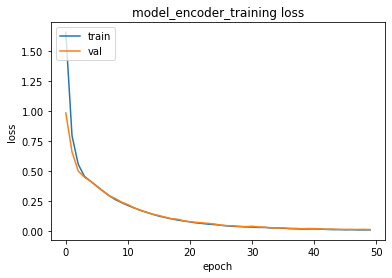

10 examples from test data...
Input                      Expected                   Predicted                     T/F
[3, 8, 7, 1, 7, 8, 6, 8]   [8, 6, 8, 8, 0, 0, 0, 0]   [8, 6, 8, 8, 0, 0, 0, 0]   True
[9, 4, 3, 3, 5, 2, 1, 7]   [2, 4, 0, 0, 0, 0, 0, 0]   [2, 4, 0, 0, 0, 0, 0, 0]   True
[2, 6, 9, 6, 2, 2, 7, 0]   [2, 2, 6, 6, 2, 0, 0, 0]   [2, 2, 6, 6, 2, 0, 0, 0]   True
[1, 9, 4, 7, 2, 0, 0, 0]   [2, 4, 0, 0, 0, 0, 0, 0]   [2, 4, 0, 0, 0, 0, 0, 0]   True
[6, 5, 9, 4, 7, 6, 0, 0]   [6, 4, 6, 0, 0, 0, 0, 0]   [6, 4, 6, 0, 0, 0, 0, 0]   True
[2, 2, 9, 6, 7, 0, 0, 0]   [6, 2, 2, 0, 0, 0, 0, 0]   [6, 2, 2, 0, 0, 0, 0, 0]   True
[9, 5, 2, 2, 9, 7, 4, 5]   [4, 2, 2, 0, 0, 0, 0, 0]   [4, 2, 2, 0, 0, 0, 0, 0]   True
[7, 2, 2, 6, 9, 4, 9, 8]   [8, 4, 6, 2, 2, 0, 0, 0]   [8, 4, 6, 2, 2, 0, 0, 0]   True
[7, 4, 1, 9, 0, 0, 0, 0]   [4, 0, 0, 0, 0, 0, 0, 0]   [4, 0, 0, 0, 0, 0, 0, 0]   True
[5, 7, 9, 6, 7, 0, 0, 0]   [6, 0, 0, 0, 0, 0, 0, 0]   [6, 0, 0, 0, 0, 0, 0, 0]   True
Accuracy:  1.0
time: 2

In [ ]:
train_test(model_encoder_training, [encoder_input_data, decoder_input_data], decoder_target_data ,
           [encoder_input_test, decoder_input_test], 
           decoder_target_test, epochs=50, batch_size=64, patience=3,verbose=2)

**IMPORTANT**: 

The above model is **ONLY** for Training. **WHY?**

**Because**:
* Teacher Forcing needs to know the correct output beforehand
* Teacher Forcing is a method for improving the training process
* The model employing Teacher Forcing CAN NOT BE USED in inference/testing

**Therefore**, 

* The model that we trained above **CAN NOT BE DIRECTLY USED** in **Inference/Testing**
* We will use some layers (with their weights) of the trained model to create a new model
* ***The new model will not use Teacher Forcing***
* Thus, the input to the new model will NOT BE  `[encoder_input_data, decoder_input_data]` as the way we designed in `model_encoder_training`

**Remember:** 

In Teacher Forcing, we set `decoder_input_data` such that it begins with a special symbol `start` and continues with the target sequence data except for the last time step.
* Now, during inference (testing), we do not know the correct (expected) target data before hand!
* We define the `decoder_input_data` as follows:
  * it begins with a special symbol `start`
  * it will continue with an input created by the decoder at the previous time step
  * in other words, the **decoder's output at time step t** will be used **decoder's input at time step t+1**



# Encoder-Decoder Model for Inference


**IMPORTANT**: 

We create **a separate encoder model** by using the trained layers in the above model.
For example, in the following model, we will use `encoder_inputs, encoder_states` for encoding which are parts of the encoder model, we trained above. That is, these layers come with its **trained weights** with Teacher Forcing 

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

time: 11 ms


## Then we create **a separate decoder model** by using the trained layers in the above model

* then design the decoder model by defining layers for:
  * inputs
  * decoding (LSTM)
  * outputs

**IMPORTANT**: pay attention that in this model we use `decoder_lstm` for decoding which is a part of the decoder model we trained above. That is this layer comes with its trained weights with Teacher Forcing 

In [ ]:
decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

time: 244 ms


* Even though we define the encoder and decoder models we still need to dynamically provide the `decoder_input_data` as follows:
  * it begins with a special symbol `start`
  * it will continue with an input created by the decoder at previous time step
  * in other words, **decoder's output at time step t** will be used **decoder's input at time step t+1**



## Let's code Encoder-Decoder model for Inference as a function

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, input_dimension))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1 
    # START (0 zero) in one-hot-encoding --> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_char)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 0 or
           len(decoded_seq) == max_output_sequence):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, input_dimension))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

time: 20.9 ms


## Let's call the function above for inference as below.

**IMPORTANT**: Since we used the trained layers in here we do NOT need to train recently created models.

In [ ]:
print('Input \t\t\t\t\t  Expected  \t\t\t   Predicted \t\tT/F')
correct =0 
sampleNo =  10
for sample in range(0,sampleNo):
  predicted= decode_sequence(encoder_input_data[sample].reshape(1,max_input_sequence,input_dimension))
  if (one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted))):
    correct+=1
  print( one_hot_decode(encoder_input_data[sample]), '\t\t', 
        one_hot_decode(decoder_target_data[sample]),'\t', predicted,
        '\t\t',one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted)))
print('Accuracy: ', correct/sampleNo)

Input 					  Expected  			   Predicted 		T/F
[3, 5, 9, 7, 7, 6, 5, 2] 		 [2, 6, 0, 0, 0, 0, 0, 0] 	 [2, 6, 0] 		 True
[2, 8, 9, 4, 6, 7, 7, 0] 		 [6, 4, 8, 2, 0, 0, 0, 0] 	 [6, 4, 8, 2, 0] 		 True
[1, 2, 9, 6, 7, 9, 7, 9] 		 [6, 2, 0, 0, 0, 0, 0, 0] 	 [6, 2, 0] 		 True
[6, 6, 8, 3, 8, 4, 0, 0] 		 [4, 8, 8, 6, 6, 0, 0, 0] 	 [4, 8, 8, 6, 6, 0] 		 True
[5, 1, 2, 2, 0, 0, 0, 0] 		 [2, 2, 0, 0, 0, 0, 0, 0] 	 [2, 2, 0] 		 True
[6, 4, 3, 3, 6, 4, 1, 0] 		 [4, 6, 4, 6, 0, 0, 0, 0] 	 [4, 6, 4, 6, 0] 		 True
[4, 9, 8, 7, 8, 5, 7, 0] 		 [8, 8, 4, 0, 0, 0, 0, 0] 	 [8, 8, 4, 0] 		 True
[3, 8, 4, 2, 3, 3, 0, 0] 		 [2, 4, 8, 0, 0, 0, 0, 0] 	 [2, 4, 8, 0] 		 True
[3, 2, 5, 6, 0, 0, 0, 0] 		 [6, 2, 0, 0, 0, 0, 0, 0] 	 [6, 2, 0] 		 True
[5, 4, 4, 2, 6, 4, 9, 8] 		 [8, 4, 6, 2, 4, 4, 0, 0] 	 [8, 4, 6, 2, 4, 4, 0] 		 True
Accuracy:  1.0
time: 3.27 s


**Notice that:** Decoder stops whenever it generates 0 (zero)

# Observations:
* Data set (X or y) can have samples whose lengths (time steps) can be different (variable)
* We use padding for appending a special symbol to sequences.
* We can pad as many as needed for a sequence to make its length equal to the maximum length in the data set.
* We use masking to tell the layer to skip these time steps since they hold padding values.
* Teacher Forcing is a method to train encoder-decoder models in Seq2Seq model to **accelerate training**
* Teacher Forcing can **ONLY** be used at Training
* We need to handle how to use the model in **inference**


# NEXT:
**Part F: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + BAHDANAU ATTENTION**